In [1]:
!source /home/bbahaduri/venv/bin/activate

In [6]:
!python3 -m ipykernel install --user --name=venv

Installed kernelspec venv in /home/bbahaduri/.local/share/jupyter/kernels/venv


In [1]:
import sys
sys.prefix

'/opt/g5k-jupyterlab'

In [1]:
import os
from pathlib import Path
import argparse
import yaml
import torch
from basics.models.SRyolo import *
#from basics.models.deeplabedsr import DeepLab
#from basics.models.sr_decoder_noBN_noD import *
#from basics.models.edsr import *

from basics.utils.datasets import create_dataloader_sr as create_dataloader
from tqdm import tqdm
from basics.utils.loss import ComputeLoss
from basics.models.common import *
import pandas as pd
from basics.utils.general import scale_coords, non_max_suppression
import torch.nn.functional as F

/home/bbahaduri/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print(torch.cuda.is_available())

True


In [5]:
#loading checkpoint and opt
device = torch.device('cuda:0')
ckpt = "/home/bbahaduri/sryolo/outputs_SAM/yoloSAM_v2_s16_unfrozen_RGB/run/train/exp3/weights/last.pt"##opt.resume if isinstance(opt.resume, str) else get_latest_run()  # specified or most recent path
assert os.path.isfile(ckpt), 'ERROR: --resume checkpoint does not exist'
#apriori = opt.global_rank, opt.local_rank
with open(Path(ckpt).parent.parent / 'opt.yaml') as f:
    opt = argparse.Namespace(**yaml.load(f, Loader=yaml.SafeLoader))  # replace
opt.weights = "/home/bbahaduri/sryolo/outputs_SAM/yoloSAM_v2_s16_unfrozen_RGB/run/train/exp3/weights/last.pt"
weights, epochs, hyp = opt.weights, opt.epochs, opt.hyp
ckpt = torch.load(weights, map_location=device)  # load checkpoint
opt.cfg, opt.weights, opt.resume, opt.batch_size, opt.global_rank, opt.local_rank = '', ckpt, True, opt.total_batch_size, 0, 0
opt.hyp = "/home/bbahaduri/sryolo/codes/models/hyp.scratch.yaml"
with open(opt.hyp,encoding='utf-8') as f:
    hyp = yaml.load(f, Loader=yaml.SafeLoader)
print(ckpt['model'])
model = Model(opt.cfg or ckpt['model'].yaml,input_mode = opt.input_mode,ch_steam=opt.ch_steam, ch=opt.ch, nc=8, anchors=hyp.get('anchors'),config=None,sr=opt.super,factor=2).to(device)  # create
exclude = ['anchor'] if (opt.cfg or hyp.get('anchors')) and not opt.resume else []  # exclude keys
state_dict = ckpt['model'].float().state_dict()  # to FP32
#state_dict = intersect_dicts(state_dict, model.state_dict(), exclude=exclude)  # intersect
model.load_state_dict(state_dict, strict=True)  # load

/home/bbahaduri/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Model(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

<All keys matched successfully>

In [6]:
# Util functions not in the article but used to render images.
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image


def display_image_with_bboxes(ax, image_id, targets_df,  bbox_df=None, id2label=None):
    image_filename = targets_df.query("image_id == @image_id").iloc[0]["path"]
    image = Image.open( image_filename).convert("RGB")

    ax.imshow(image)
    ax.axis("off")
    if bbox_df is not None:
        bboxes = bbox_df.query("image_id == @image_id")[["xmin", "ymin", "xmax", "ymax"]].values
        labels = bbox_df.query("image_id == @image_id")["label_id"].values
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, :]
            bot_left = (bbox[0]/2, bbox[1]/2)
            width = bbox[2]/2 - bbox[0]/2
            height = bbox[3]/2 - bbox[1]/2


            label = labels[i]#id2label.get(labels[i], "unknown")
            ax.text(
                bbox[0]+2,
                bbox[1]-2,
                label,
                color="white",
                verticalalignment="bottom",
                horizontalalignment="left",
                fontsize="medium",
                fontweight="bold",
                bbox=dict(facecolor="black", edgecolor=None),
                zorder=1
            )

            outer_box = patches.Rectangle(
                bot_left, width, height, linewidth=4, edgecolor="black", fill=False, zorder=2
            )
            inner_box = patches.Rectangle(
                bot_left, width, height, linewidth=2, edgecolor="white", fill=False, zorder=3
            )
                # Add the patch to the Axes
            ax.add_patch(outer_box)
            ax.add_patch(inner_box)

# def get_utils_variables(data_path=DATA_PATH):
#     images_path = data_path / "images"
#     annotations_path = data_path / "annotations.json"

#     with open(annotations_path, "r") as f:
#         targets_json = json.load(f)
    
#     id2label = {cat["id"]: cat["name"] for cat in targets_json["categories"]}
#     return images_path, id2label

# images_path, id2label = get_utils_variables()
# plt.figure(figsize=(18,6))
# image_ids = [397133, 37777, 252219]
# for i, image_id in enumerate(image_ids):
#     ax = plt.subplot(131+i)
#     display_image_with_bboxes(ax, image_id, images_df, images_path, targets_df, id2label);
#     plt.title(f"Image ID: {image_id}")

In [7]:
#for dataloader purpose
def colorstr(*input):
    # Colors a string https://en.wikipedia.org/wiki/ANSI_escape_code, i.e.  colorstr('blue', 'hello world')
    *args, string = input if len(input) > 1 else ('blue', 'bold', input[0])  # color arguments, string
    colors = {'black': '\033[30m',  # basic colors
              'red': '\033[31m',
              'green': '\033[32m',
              'yellow': '\033[33m',
              'blue': '\033[34m',
              'magenta': '\033[35m',
              'cyan': '\033[36m',
              'white': '\033[37m',
              'bright_black': '\033[90m',  # bright colors
              'bright_red': '\033[91m',
              'bright_green': '\033[92m',
              'bright_yellow': '\033[93m',
              'bright_blue': '\033[94m',
              'bright_magenta': '\033[95m',
              'bright_cyan': '\033[96m',
              'bright_white': '\033[97m',
              'end': '\033[0m',  # misc
              'bold': '\033[1m',
              'underline': '\033[4m'}
    return ''.join(colors[x] for x in args) + f'{string}' + colors['end']

In [8]:
gs = max(int(model.stride.max()), 32)
test_path = "/home/bbahaduri/sryolo/sryolo_data/VEDAIdataset/VEDAI/fold01test_write.txt"
testloader = create_dataloader(test_path, 512, 1, gs, opt,  # testloader     #*changed  batch_size//2
                                    hyp=hyp, cache=opt.cache_images and not opt.notest, rect=False, rank=-1,
                                    #world_size=opt.world_size, 
                                    workers=opt.workers,pad=0.5,
                                    prefix=colorstr('val: '))[0]

val: Scanning '/home/bbahaduri/sryolo/sryolo_data/VEDAIdataset/VEDAI/labels.cache' for images and labels... 121 found, 0 missing, 2 empty, 0 corrupted: 100%|██████████| 121/121 [00:00<?, ?it/s]


In [9]:
nl =1
nc = 8
imgsz = 512
names=  ['car', 'pickup', 'camping','truck', 'other', 'tractor', 'boat', 'van']
hyp['box'] *= 3. / nl  # scale to layers
hyp['cls'] *= nc / 80. * 3. / nl  # scale to classes and layers
hyp['obj'] *= (imgsz / 640) ** 2 * 3. / nl  # scale to image size and layers
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.gr = 1.0  # iou loss ratio (obj_loss = 1.0 or iou)
#model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
model.names = names

In [ ]:
        with torch.no_grad():
            # Run model
            try:
                out, train_out = model(img,ir,input_mode="RGB") #zjq inference and training outputs
            except:
                out, train_out,_ = model(img,ir,input_mode="RGB") #zjq inference and training outputs
        target_id =0
        for target in targets:
             df = df.append(pd.DataFrame([[target_id, img_id, target[1], target[2], target[3], target[4], target[5]]]))
             target_id +=1

In [10]:
device = torch.device('cuda:0')
dataloader = testloader
model.eval()
img_id = 0
targets_dfs = []##pd.DataFrame(columns=["target_id", "image_id", "label_id", "xmin", "ymin", "xmax", "ymax"])
preds_dfs = []##pd.DataFrame(columns= [ "pred_id", "image_id", "label_id", "xmin", "ymin", "xmax", "ymax", "score", "image_loss", ])
compute_loss = ComputeLoss(model)
for batch_i, (img, ir, targets, paths, shapes) in enumerate(tqdm(dataloader, desc="")): #zjq
        img = img.to(device, non_blocking=True).float()
        # img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        ir = ir.to(device, non_blocking=True).float()
        # ir = ir.half() if half else ir.float()  # uint8 to fp16/32
        ir /= 255.0  # 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = img.shape
        #print(img.shape)
        #print(shapes)
        #print(paths)
        #print("targets", targets)
        nb, _, height, width = img.shape  # batch size, channels, height, width
        #img=F.interpolate(img,size=[i//2 for i in img.size()[2:]], mode='bilinear', align_corners=True)  #* added for SAM backbone
        #img=F.interpolate(img,size=[i*2 for i in img.size()[2:]], mode='bilinear', align_corners=True)  #* added for SAM backbone
        #[0.00000, 0.00000, 0.03357, 0.21543, 0.01953, 0.03516]
        #print("img shape: ", img.shape)
        with torch.no_grad():
            # Run model
            try:
                out, train_out = model(img,ir,input_mode="RGB") #zjq inference and training outputs
            except:
                out, train_out,_ = model(img,ir,input_mode="RGB") #zjq inference and training outputs
        #breakpoint()
        #print(train_out)
        target_id =0
        targetsn = targets.clone()
        # targetsn[:, 4] = targetsn[:, 2] + targetsn[:,4]
        # targetsn[:, 5] = targetsn[:, 3] + targetsn[:, 5]
        scale_coords(img[0].shape[1:], targetsn[:, 2:6], shapes[0][0], shapes[0][1])
        targetsn[:, 2:] *= torch.Tensor([width, height, width, height]).to(device) 
        for target in targetsn:
            #xmax = target[2] + target[4]
            #ymax = target[3] + target[5]
            xmin = target[2] - target[4] / 2  # top left x
            ymin = target[3] - target[5] / 2  # top left y
            xmax = target[2] + target[4] / 2  # bottom right x
            ymax = target[3] + target[5] / 2  # bottom right y
            #df = df.append(pd.DataFrame([[target_id, img_id, target[1], target[2], target[3], xmax, ymax]]))
            targets_dfs.append(#preds_dfs.append(
            pd.DataFrame([
                    {
                    #"target_id": target_id,
                    "image_id": img_id,
                    "label_id": target[1].to("cpu").item(),   # preds[0]["labels"].to("cpu"),
                    "xmin": xmin.to("cpu").item() *2,    #preds[0]["boxes"][:, 0].to("cpu"),
                    "ymin": ymin.to("cpu").item() *2,    #preds[0]["boxes"][:, 1].to("cpu"),
                    "xmax": xmax.to("cpu").item() *2,    #preds[0]["boxes"][:, 2].to("cpu"),
                    "ymax": ymax.to("cpu").item() *2,    #preds[0]["boxes"][:, 3].to("cpu"),
                    "path": paths[0],
                    }
                    ]
                )
            )
            target_id +=1
        
        losses = compute_loss([x.float() for x in train_out], targets)[0][:3]  # box, obj, cls
        loss = losses.item()#sum(losses.values()).item()
        #print(loss)
        conf_thres=0.2
        iou_thres=0.7
        #breakpoint()
        #print(out[0].shape)
        out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=(), multi_label=True)        
        #print(out[0].shape)
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            path = Path(paths[si])
            #seen += 1

            if len(pred) == 0:
                #if nl:
                    #stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            predn = pred.clone()
            #scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred

            gn = torch.tensor(shapes[si][0])[[1, 0, 1, 0]]
            

            preds_dfs.append(#preds_dfs.append(
            pd.DataFrame(
                    {
                    "image_id": img_id,
                    "image_loss": loss,
                    "label_id": predn[:, 5].to("cpu"),   # preds[0]["labels"].to("cpu"),
                    "score": predn[:, 4].to("cpu"),      ##preds[0]["scores"].to("cpu"),
                    "xmin": predn[:, 0].to("cpu")*2,    #preds[0]["boxes"][:, 0].to("cpu"),
                    "ymin": predn[:, 1].to("cpu")*2,    #preds[0]["boxes"][:, 1].to("cpu"),
                    "xmax": predn[:, 2].to("cpu")*2,    #preds[0]["boxes"][:, 2].to("cpu"),
                    "ymax": predn[:, 3].to("cpu")*2,    #preds[0]["boxes"][:, 3].to("cpu"),
                    }
                )
            )
            
        img_id +=1
        
preds_df = pd.concat(preds_dfs, ignore_index=True)
preds_df = preds_df.reset_index().rename(columns={"index": "pred_id"})
targets_df = pd.concat(targets_dfs, ignore_index=True)
targets_df.reset_index(inplace=True)
targets_df.rename(columns={"index": "target_id", "category_id": "label_id"}, inplace=True)


  0%|          | 0/121 [00:00<?, ?it/s]/home/bbahaduri/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 121/121 [02:08<00:00,  1.06s/it] 


In [27]:
preds_df.head(10)

,pred_id,image_id,image_loss,label_id,score,xmin,ymin,xmax,ymax
0,0,0,0.111461,4.0,0.337335,479.877625,106.766891,504.033752,170.259232
1,1,1,0.065650,0.0,0.879254,71.920403,343.962708,81.522079,364.642792
2,2,1,0.065650,7.0,0.858201,252.419922,341.694824,262.137543,364.622681
3,3,1,0.065650,7.0,0.856725,196.371964,342.469208,205.910385,364.668610
4,4,1,0.065650,0.0,0.832085,299.348328,381.269104,321.105713,391.268860
5,5,1,0.065650,3.0,0.802974,295.581390,349.262390,321.097961,360.664093
6,6,1,0.065650,3.0,0.779499,222.829514,411.615051,253.203049,422.696350
7,7,1,0.065650,3.0,0.724670,237.837204,495.253296,265.620819,507.758362
8,8,2,0.081430,1.0,0.871770,338.887421,176.836700,362.425995,185.475479
9,9,2,0.081430,0.0,0.865642,45.328384,247.794205,65.330704,257.059296


In [28]:
targets_df.head(10)

,target_id,image_id,label_id,xmin,ymin,xmax,ymax,path
0,0,0,1.0,898.974609,172.519485,918.974609,220.519485,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
1,1,1,0.0,143.633743,686.933533,163.633743,726.933533,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
2,2,1,7.0,391.462677,681.560669,415.462677,731.560669,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
3,3,1,3.0,433.124756,822.213074,507.124756,844.213074,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
4,4,1,3.0,477.870300,991.940796,529.870300,1011.940796,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
5,5,1,0.0,596.767883,760.806641,644.767883,784.806641,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
6,6,1,3.0,594.327209,699.908752,648.327209,721.908752,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
7,7,1,7.0,507.354553,682.769104,525.354553,728.769104,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
8,8,1,2.0,786.925110,76.685890,826.925110,100.685890,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...
9,9,1,2.0,787.670837,110.872131,827.670837,132.872131,/home/bbahaduri/sryolo/sryolo_data/VEDAIdatase...


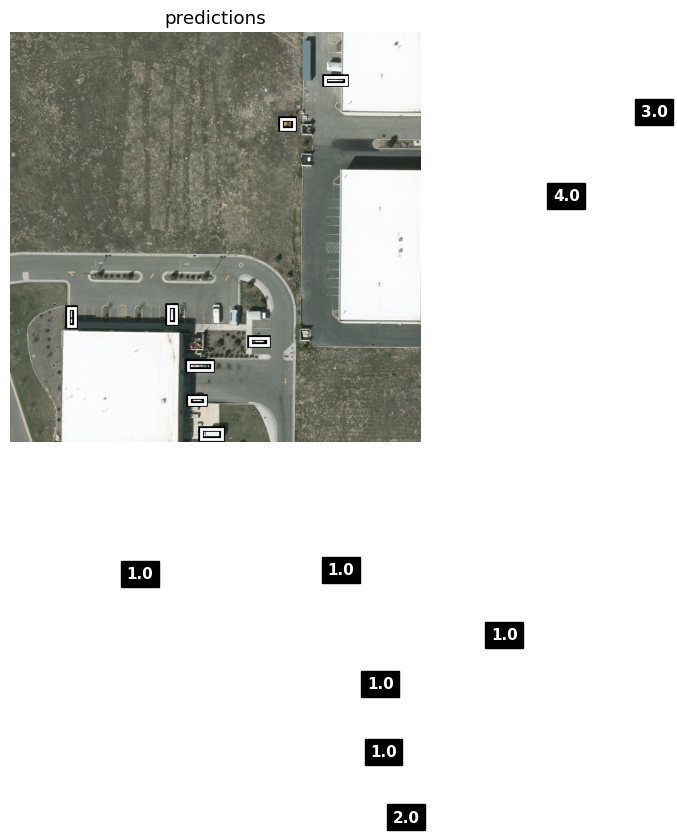

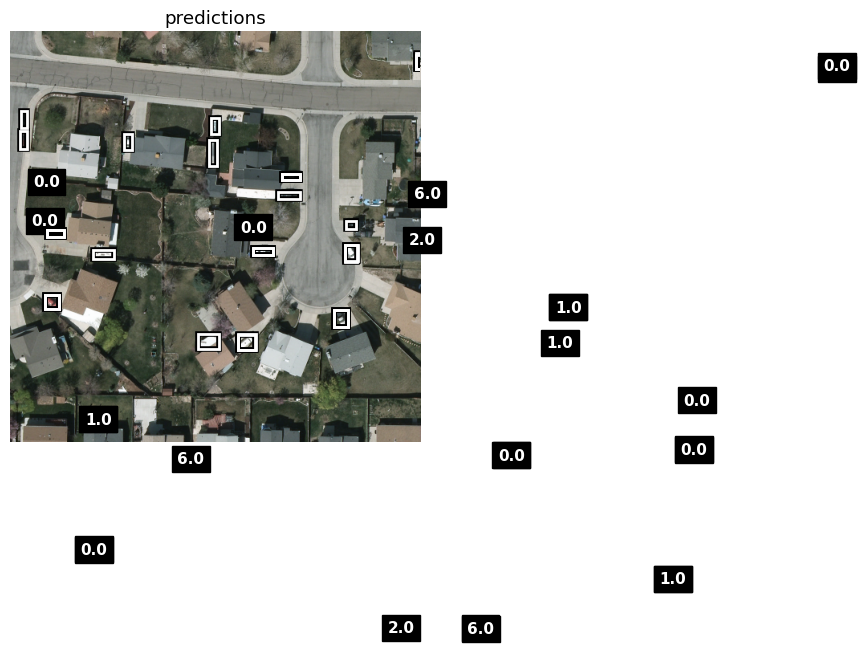

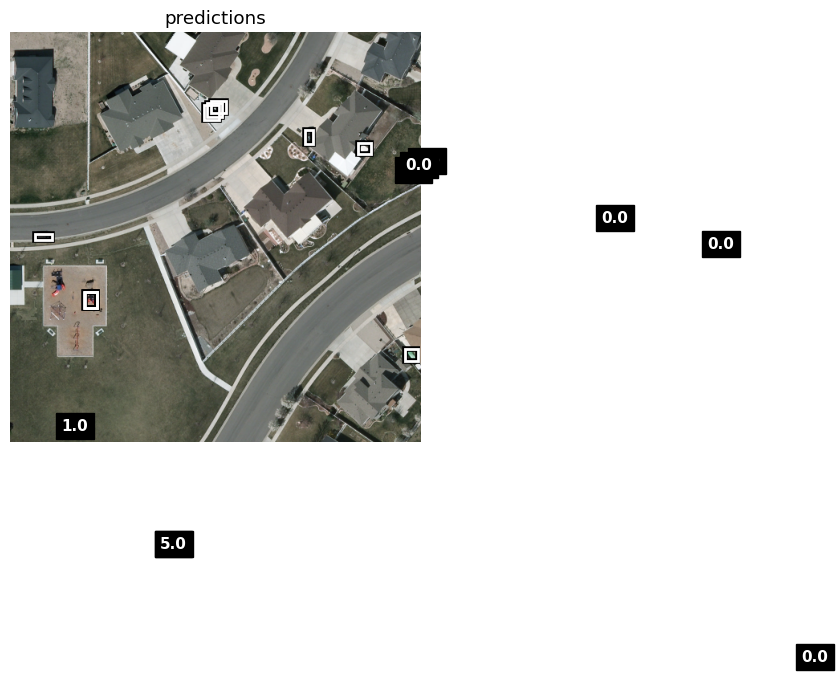

In [11]:
image_ids = [2, 3, 4]  # IDs found manually in the necessary loss ranges
for image_id in image_ids:
    plt.figure(figsize=(18,6))
    ax = plt.subplot(131)
    display_image_with_bboxes(ax, image_id, targets_df, bbox_df=preds_df, id2label=None);
    plt.title(f"Image ID: {image_id}")
    # ax = plt.subplot(132)
    # display_image_with_bboxes(ax, image_id, images_df, images_path, targets_df, id2label);
    # plt.title("targets")
    # ax = plt.subplot(133)
    # display_image_with_bboxes(ax, image_id, images_df, images_path, preds_df, id2label);
    plt.title("predictions")
    plt.show()

In [12]:
# Copyright © 2022 Bernat Puig Camps
from typing import Dict, Set, Tuple

import numpy as np
import pandas as pd
import torch
import torchvision

TARGETS_DF_COLUMNS = [
    "target_id",
    "image_id",
    "label_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
]
PREDS_DF_COLUMNS = [
    "pred_id",
    "image_id",
    "label_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "score",
]
ERRORS_DF_COLUMNS = ["pred_id", "target_id", "error_type"]

BACKGROUND_IOU_THRESHOLD = 0.1
FOREGROUND_IOU_THRESHOLD = 0.5


class ErrorType:
    OK = "correct"  # pred -> IoU > foreground; target_label == pred_label; highest score
    CLS = "classification"  # pred -> IoU > foreground; target_label != pred_label
    LOC = "localization"  # pred -> background < IoU < foreground; target_label == pred_label
    CLS_LOC = "cls & loc"  # pred -> background < IoU < foreground; target_label != pred_label
    DUP = "duplicate"  # pred -> background < IoU < foreground; target_label != pred_label
    BKG = "background"  # pred -> IoU > foreground; target_label == pred_label; no highest score
    MISS = "missed"  # target -> No pred with Iou > background


def classify_predictions_errors(
    targets_df: pd.DataFrame,
    preds_df: pd.DataFrame,
    iou_background: float = BACKGROUND_IOU_THRESHOLD,
    iou_foreground: float = FOREGROUND_IOU_THRESHOLD,
) -> pd.DataFrame:
    """Classify predictions
    We assume model is right as much as possible. Thus, in case of doubt
    (i.e matching two targets), a prediction will be first considered
    ErrorType.LOC before ErrorType.CLS.
    The error definition credit belongs to the following paper (refer to it for
    conceptual details):
        TIDE: A General Toolbox for Identifying Object Detection Errors
        https://arxiv.org/abs/2008.08115
    :param targets_df: DataFrame with all targets for all images with TARGETS_DF_COLUMNS.
    :param preds_df: DataFrame with all predictions for all images with PREDS_DF_COLUMNS.
    :param iou_background: Minimum IoU for a prediction not to be considered background.
    :param iou_foreground: Minimum IoU for a prediction to be considered foreground.
    :return errors_df: DataFrame with all error information with ERRORS_DF_COLUMNS
    """

    # Provide clarity on expectations and avoid confusing errors down the line
    assert (set(TARGETS_DF_COLUMNS) - set(targets_df.columns)) == set()
    assert (set(PREDS_DF_COLUMNS) - set(preds_df.columns)) == set()

    pred2error = dict()  # {pred_id: ErrorType}
    target2pred = (
        dict()
    )  # {target_id: pred_id}, require iou > iou_foreground & max score
    pred2target = dict()  # {pred_id: target_id}, require iou >= iou_background
    missed_targets = set()  # {target_id}

    # Higher scoring preds take precedence when multiple fulfill criteria
    preds_df = preds_df.sort_values(by="score", ascending=False)

    for image_id, im_preds_df in preds_df.groupby("image_id"):
        # Need to reset index to access dfs with same idx we access
        #   IoU matrix down the line
        im_targets_df = targets_df.query("image_id == @image_id").reset_index(
            drop=True
        )
        im_preds_df = im_preds_df.reset_index(drop=True)

        if im_targets_df.empty:
            pred2error = {**pred2error, **_process_empty_image(im_preds_df)}
        else:
            iou_matrix, iou_label_match_matrix = _compute_iou_matrices(
                im_targets_df, im_preds_df
            )

            # Iterate over all predictions. Higher scores first
            for pred_idx in range(len(im_preds_df)):
                match_found = _match_pred_to_target_with_same_label(
                    pred_idx,
                    pred2error,
                    pred2target,
                    target2pred,
                    iou_label_match_matrix,
                    im_targets_df,
                    im_preds_df,
                    iou_background,
                    iou_foreground,
                )
                if match_found:
                    continue

                _match_pred_wrong_label_or_background(
                    pred_idx,
                    pred2error,
                    pred2target,
                    iou_matrix,
                    im_targets_df,
                    im_preds_df,
                    iou_background,
                    iou_foreground,
                )

    missed_targets = _find_missed_targets(targets_df, pred2target)
    errors_df = _format_errors_as_dataframe(
        pred2error, pred2target, missed_targets
    )
    return errors_df[list(ERRORS_DF_COLUMNS)]


def _process_empty_image(im_preds_df: pd.DataFrame) -> Dict[int, str]:
    """In an image without targets, all predictions represent a background error"""
    return {
        pred_id: ErrorType.BKG for pred_id in im_preds_df["pred_id"].unique()
    }


def _compute_iou_matrices(
    im_targets_df: pd.DataFrame, im_preds_df: pd.DataFrame
) -> Tuple[np.array, np.array]:
    """Compute IoU matrix between all targets and preds in the image
    :param im_targets_df: DataFrame with targets for the image being processed.
    :param im_preds_df: DataFrame with preds for the image being processed.
    :return:
        iou_matrix: Matrix of size (n_targets, n_preds) with IoU between all
            targets & preds
        iou_label_match_matrix: Same as `iou_matrix` but 0 for all target-pred
            pair with different labels (i.e. IoU kept only if labels match).
    """
    # row indexes point to targets, column indexes to predictions
    iou_matrix = iou_matrix = torchvision.ops.box_iou(
        torch.from_numpy(
            im_targets_df[["xmin", "ymin", "xmax", "ymax"]].values
        ),
        torch.from_numpy(im_preds_df[["xmin", "ymin", "xmax", "ymax"]].values),
    ).numpy()

    # boolean matrix with True iff target and pred have the same label
    label_match_matrix = (
        im_targets_df["label_id"].values[:, None]
        == im_preds_df["label_id"].values[None, :]
    )
    # IoU matrix with 0 in all target-pred pairs that have different label
    iou_label_match_matrix = iou_matrix * label_match_matrix
    return iou_matrix, iou_label_match_matrix


def _match_pred_to_target_with_same_label(
    pred_idx: int,
    pred2error: Dict[int, str],
    pred2target: Dict[int, int],
    target2pred: Dict[int, int],
    iou_label_match_matrix: np.array,
    im_targets_df: pd.DataFrame,
    im_preds_df: pd.DataFrame,
    iou_background: float,
    iou_foreground: float,
) -> bool:
    """Try to match `pred_idx` to a target with the same label and identify error (if any)
    If there is a match `pred2error`, `pred2target` and (maybe) `target2pred`
    are modified in place.
    Possible error types found in this function:
        ErrorType.OK, ErrorType.DUP, ErrorType.LOC
    :param pred_idx: Index of prediction based on score (index 0 is maximum score for image).
    :param pred2error: Dict mapping pred_id to error type.
    :param pred2target: Dict mapping pred_id to target_id (if match found with iou above background)
    :param target2pred: Dict mapping target_id to pred_id to pred considered correct (if any).
    :param iou_label_match_matrix: Matrix with size [n_targets, n_preds] with IoU between all preds
        and targets that share label (i.e. IoU = 0 if there is a label missmatch).
    :param im_targets_df: DataFrame with targets for the image being processed.
    :param im_preds_df: DataFrame with preds for the image being processed.
    :param iou_background: Minimum IoU to consider a pred not background for target.
    :param iou_foreground: Minimum IoU to consider a pred foreground for a target.
    :return matched: Whether or not there was a match and we could identify the pred error.
    """
    # Find highest overlapping target for pred processed
    target_idx = np.argmax(iou_label_match_matrix[:, pred_idx])
    iou = np.max(iou_label_match_matrix[:, pred_idx])
    target_id = im_targets_df.at[target_idx, "target_id"]
    pred_id = im_preds_df.at[pred_idx, "pred_id"]

    matched = False
    if iou >= iou_foreground:
        pred2target[pred_id] = target_id
        # Check if another prediction is already the match for target to
        #   identify duplicates
        if target2pred.get(target_id) is None:
            target2pred[target_id] = pred_id
            pred2error[pred_id] = ErrorType.OK
        else:
            pred2error[pred_id] = ErrorType.DUP
        matched = True

    elif iou_background <= iou < iou_foreground:
        pred2target[pred_id] = target_id
        pred2error[pred_id] = ErrorType.LOC
        matched = True
    return matched


def _match_pred_wrong_label_or_background(
    pred_idx: int,
    pred2error: Dict[int, str],
    pred2target: Dict[int, int],
    iou_matrix: np.array,
    im_targets_df: pd.DataFrame,
    im_preds_df: pd.DataFrame,
    iou_background: float,
    iou_foreground: float,
) -> None:
    """Try to match `pred_idx` to a target (with different label) and identify error
    If there is a match `pred2error` and  (maybe) `pred2target` are modified in place.
    Possible error types found in this function:
        ErrorType.BKG, ErrorType.CLS, ErrorType.CLS_LOC
    :param pred_idx: Index of prediction based on score (index 0 is maximum score for image).
    :param pred2error: Dict mapping pred_id to error type.
    :param pred2target: Dict mapping pred_id to target_id (if match found with iou above background)
    :param target2pred: Dict mapping target_id to pred_id to pred considered correct (if any).
    :param iou: Matrix with size [n_targets, n_preds] with IoU between all preds and targets.
    :param im_targets_df: DataFrame with targets for the image being processed.
    :param im_preds_df: DataFrame with preds for the image being processed.
    :param iou_background: Minimum IoU to consider a pred not background for target.
    :param iou_foreground: Minimum IoU to consider a pred foreground for a target.
    """
    # Find highest overlapping target for pred processed
    target_idx = np.argmax(iou_matrix[:, pred_idx])
    iou = np.max(iou_matrix[:, pred_idx])
    target_id = im_targets_df.at[target_idx, "target_id"]
    pred_id = im_preds_df.at[pred_idx, "pred_id"]

    if iou < iou_background:
        pred2error[pred_id] = ErrorType.BKG

    # preds with correct label do not get here. Thus, no need to check if label
    #   is wrong
    elif iou >= iou_foreground:
        pred2target[pred_id] = target_id
        pred2error[pred_id] = ErrorType.CLS
    else:
        # No match to target, as we cannot be sure model was remotely close to
        #   getting it right
        pred2error[pred_id] = ErrorType.CLS_LOC


def _find_missed_targets(
    im_targets_df: pd.DataFrame, pred2target: Dict[int, int]
) -> Set[int]:
    """Find targets in the processed image that were not matched by any prediction
    :param im_targets_df: DataFrame with targets for the image being processed.
    :param pred2target: Dict mapping pred_id to target_id (if match found with
        iou above background)
    :return missed_targets: Set of all the target ids that were missed
    """
    matched_targets = [t for t in pred2target.values() if t is not None]
    missed_targets = set(im_targets_df["target_id"]) - set(matched_targets)
    return missed_targets


def _format_errors_as_dataframe(
    pred2error: Dict[int, str],
    pred2target: Dict[int, int],
    missed_targets: Set[int],
) -> pd.DataFrame:
    """Use the variables used to classify errors to format them in a ready to use DataFrame
    :param pred2error: Dict mapping pred_id to error type.
    :param pred2target: Dict mapping pred_id to target_id (if match found with
        iou above background)
    :param missed_targets: Set of all the target ids that were missed
    :return: DataFrame with columns ERRORS_DF_COLUMNS
    """
    errors_df = pd.DataFrame.from_records(
        [
            {"pred_id": pred_id, "error_type": error}
            for pred_id, error in pred2error.items()
        ]
    )
    errors_df["target_id"] = None
    errors_df.set_index("pred_id", inplace=True)
    for pred_id, target_id in pred2target.items():
        errors_df.at[pred_id, "target_id"] = target_id

    missed_df = pd.DataFrame(
        {
            "pred_id": None,
            "error_type": ErrorType.MISS,
            "target_id": list(missed_targets),
        }
    )
    errors_df = pd.concat(
        [errors_df.reset_index(), missed_df], ignore_index=True
    ).astype(
        {"pred_id": float, "target_id": float, "error_type": pd.StringDtype()}
    )
    return errors_df

In [13]:
errors_df = classify_predictions_errors(targets_df, preds_df)

In [16]:
errors_df.head()

,pred_id,target_id,error_type
0,0.0,7.0,localization
1,1.0,1.0,localization
2,2.0,4.0,localization
3,3.0,0.0,localization
4,4.0,NaN,background


In [40]:
error_class = pd.merge(errors_df, targets_df, on='target_id')

In [41]:
error_class[error_class['error_type'] == 'missed']["label_id"].value_counts()

label_id
1.0    8
2.0    8
3.0    7
0.0    6
6.0    6
5.0    4
4.0    3
Name: count, dtype: int64

In [42]:
error_class[error_class['error_type'] == 'classification']["label_id"].value_counts()

label_id
1.0    23
0.0    20
4.0     8
6.0     6
3.0     5
7.0     3
2.0     2
5.0     2
Name: count, dtype: int64

In [14]:
targets_df.info

<bound method DataFrame.info of      target_id  image_id  label_id      xmin      ymin      xmax      ymax
0            0         0       5.0  0.822151  0.163508  0.863167  0.194758
1            1         0       5.0  0.748981  0.082433  0.784137  0.107823
2            2         0       5.0  0.901970  0.088506  0.933220  0.111944
3            3         0       3.0  0.514191  0.214076  0.598176  0.253139
4            4         0       2.0  0.486161  0.241690  0.562333  0.274893
..         ...       ...       ...       ...       ...       ...       ...
359        359       116       1.0  0.531213  0.951397  0.550744  1.000225
360        360       117       1.0  0.856751  0.891347  0.876283  0.934316
361        361       118       1.0  0.717272  0.311309  0.736804  0.354277
362        362       119       0.0  0.040637  0.456125  0.058215  0.499094
363        363       120       1.0  0.930309  0.485129  0.951793  0.526145

[364 rows x 7 columns]>

In [14]:
errors_df["error_type"].value_counts()

error_type
correct           232
classification    143
background        104
missed             76
cls & loc          18
localization       13
duplicate           8
Name: count, dtype: Int64

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

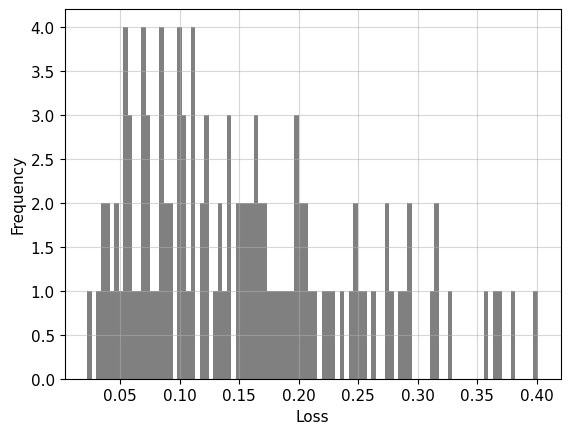

In [15]:
preds_df.groupby("image_id")["image_loss"].first().plot.hist(bins=100, color="gray");
plt.xlabel("Loss")
plt.grid(alpha=0.5)
plt.show()

In [19]:
preds_df.info

<bound method DataFrame.info of      pred_id  image_id  image_loss  label_id     score      xmin      ymin  \
0          0         0    0.526446       5.0  0.820262  0.897297  0.318698   
1          1         0    0.526446       5.0  0.798789  0.730019  0.067918   
2          2         0    0.526446       2.0  0.783799  0.443873  0.226849   
3          3         0    0.526446       5.0  0.361296  0.781621  0.149598   
4          4         0    0.526446       3.0  0.357679  0.612228  0.071708   
..       ...       ...         ...       ...       ...       ...       ...   
379      379       118    0.061237       1.0  0.420452  0.705885  0.291471   
380      380       118    0.061237       0.0  0.230992  0.705813  0.291003   
381      381       119    0.047919       0.0  0.785003  0.030430  0.436135   
382      382       120    0.069536       0.0  0.363898  0.921538  0.466600   
383      383       120    0.069536       1.0  0.320470  0.921484  0.466487   

         xmax      ymax  
0    

In [18]:
!pip3 install torchmetrics

     |████████████████████████████████| 519 kB 2.2 MB/s eta 0:00:01
  Using cached torch-2.0.1-cp39-cp39-manylinux1_x86_64.whl (619.9 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [16]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class MyMeanAveragePrecision:
    """Wrapper for the torchmetrics MeanAveragePrecision exposing API we need"""

    def __init__(self, foreground_threshold):
        self.device = (
            torch.device("cuda:0")
            if torch.cuda.is_available()
            else torch.device("cpu")
        )
        self.map = MeanAveragePrecision(
            iou_thresholds=[foreground_threshold]
        ).to(self.device)

    def __call__(self, targets_df, preds_df):
        targets, preds = self._format_inputs(targets_df, preds_df)
        self.map.update(preds=preds, target=targets)
        result = self.map.compute()["map"].item()
        self.map.reset()
        return result

    def _format_inputs(self, targets_df, preds_df):
        image_ids = set(targets_df["image_id"]) | set(preds_df["image_id"])
        targets, preds = [], []
        for image_id in image_ids:
            im_targets_df = targets_df.query("image_id == @image_id")
            im_preds_df = preds_df.query("image_id == @image_id")
            targets.append(
                {
                    "boxes": torch.as_tensor(
                        im_targets_df[["xmin", "ymin", "xmax", "ymax"]].values,
                        dtype=torch.float32,
                    ).to(self.device),
                    "labels": torch.as_tensor(
                        im_targets_df["label_id"].values, dtype=torch.int64
                    ).to(self.device),
                }
            )
            preds.append(
                {
                    "boxes": torch.as_tensor(
                        im_preds_df[["xmin", "ymin", "xmax", "ymax"]].values,
                        dtype=torch.float32,
                    ).to(self.device),
                    "labels": torch.as_tensor(
                        im_preds_df["label_id"].values, dtype=torch.int64
                    ).to(self.device),
                    "scores": torch.as_tensor(
                        im_preds_df["score"].values, dtype=torch.float32
                    ).to(self.device),
                }
            )
        return targets, preds

In [17]:
from typing import Callable, Dict, Tuple

import pandas as pd


def calculate_error_impact(
    metric_name: str,
    metric: Callable,
    errors_df: pd.DataFrame,
    targets_df: pd.DataFrame,
    preds_df: pd.DataFrame,
) -> Dict[str, float]:
    """Calculate the `metric` and the independant impact each error type has on it

    Impact is defined as the (metric_after_fixing - metric_before_fixing).
    Note that all error impacts and the metric will not add to 1. Nonetheless,
    the errors (and fixes) are defined in such a way that applying all fixes
    would end up with a perfect metric score.

    :param metric_name: Name of the metric to display for logging purposes.
    :param metric: Callable that will be called as metric(targets_df, preds_df)
        and returns a float.
    :param errors_df: DataFrame with error classification for all preds and targets
    :param targets_df: DataFrame with the targets.
    :param preds_df: DataFrame with the predictions.
    :return impact: Dictionary with one key for the metric without fixing and
        one for each error type.
    """

    ensure_consistency(errors_df, targets_df, preds_df)

    metric_values = {
        ErrorType.CLS: metric(*fix_cls_error(errors_df, targets_df, preds_df)),
        ErrorType.LOC: metric(*fix_loc_error(errors_df, targets_df, preds_df)),
        ErrorType.CLS_LOC: metric(
            *fix_cls_loc_error(errors_df, targets_df, preds_df)
        ),
        ErrorType.DUP: metric(*fix_dup_error(errors_df, targets_df, preds_df)),
        ErrorType.BKG: metric(*fix_bkg_error(errors_df, targets_df, preds_df)),
        ErrorType.MISS: metric(
            *fix_miss_error(errors_df, targets_df, preds_df)
        ),
    }

    # Compute the metric on the actual results
    baseline_metric = metric(targets_df, preds_df)
    # Calculate the difference (impact) in the metric when fixing each error
    impact = {
        error: (error_metric - baseline_metric)
        for error, error_metric in metric_values.items()
    }
    impact[metric_name] = baseline_metric
    return impact


def ensure_consistency(
    errors_df: pd.DataFrame, targets_df: pd.DataFrame, preds_df: pd.DataFrame
):
    """Make sure that all targets are preds are accounted for in errors"""
    target_ids = set(targets_df["target_id"])
    pred_ids = set(preds_df["pred_id"])
    print(type(errors_df))
    error_target_ids = set(errors_df.loc[errors_df['target_id'].notnull()]["target_id"])  # errors_df.query("target_id.notnull()")
    error_pred_ids = set(errors_df.loc[errors_df['pred_id'].notnull()]["pred_id"])#errors_df.query("pred_id.notnull()"

    if not target_ids == error_target_ids:
        raise ValueError(
            f"Missing target IDs in error_df: {target_ids - error_target_ids}"
        )

    if not pred_ids == error_pred_ids:
        raise ValueError(
            f"Missing pred IDs in error_df: {pred_ids - error_pred_ids}"
        )


def fix_cls_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return _fix_by_correcting_and_removing_preds(
        errors_df, targets_df, preds_df, ErrorType.CLS
    )


def fix_loc_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return _fix_by_correcting_and_removing_preds(
        errors_df, targets_df, preds_df, ErrorType.LOC
    )


def fix_cls_loc_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return _fix_by_removing_preds(
        errors_df, targets_df, preds_df, ErrorType.CLS_LOC
    )


def fix_bkg_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return _fix_by_removing_preds(
        errors_df, targets_df, preds_df, ErrorType.BKG
    )


def fix_dup_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return _fix_by_removing_preds(
        errors_df, targets_df, preds_df, ErrorType.DUP
    )


def fix_miss_error(
    errors_df, targets_df, preds_df
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Fix missed targets by removing them

    Missed targets is the only type of errors that deals with targets rather
    than predictions

    :return: Fixed (`targets_df`, `errors_df`)
    """
    ensure_consistency(errors_df, targets_df, preds_df)

    targets_df = targets_df.merge(
        # Need to filter rest of errors or multi prediction per target makes
        #   target_df bigger
        errors_df.query("error_type == 'missed'"),#@ErrorType.MISS"),
        on="target_id",
        how="left",
    )#*.query("error_type.isnull()")
    targets_df = targets_df.loc[targets_df['error_type'].isnull()]
    return targets_df[TARGETS_DF_COLUMNS], preds_df


def _fix_by_correcting_and_removing_preds(
    errors_df: pd.DataFrame,
    targets_df: pd.DataFrame,
    preds_df: pd.DataFrame,
    error_type: ErrorType,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Correct predictions of `error_type` of unmatched target and remove the rest

    CLS and LOC errors are matched to targets. To assess their impact, we
    correct the highest scoring prediction for an unmatched target
    (no OK error for it).
        - For CLS, we set the label to the right one.
        - For LOC, we set the bounding box to match perfectly with the target's.

    The non-corrected predictions of `error_type` are removed from `preds_df`.

    The idea is to assess what happened if instead of missing a target due to an
    incorrect prediction, we would have had a correct one instead. The ones that
    are not highest-scoring for target would have been duplicates, so we remove
    them.

    :return: Fixed (`targets_df`, `errors_df`)
    """

    assert error_type in {
        ErrorType.CLS,
        ErrorType.LOC,
    }, f"error_type='{error_type}'"
    ensure_consistency(errors_df, targets_df, preds_df)

    cols_to_correct = {
        ErrorType.CLS: ["label_id"],
        ErrorType.LOC: ["xmin", "ymin", "xmax", "ymax"],
    }[error_type]

    # Add matched targets to relevant preds and sort so highest scoring is first.
    preds_df = (
        preds_df.merge(
            errors_df.query(
                "error_type in ['correct', 'classification', 'localization']"#@ErrorType.OK, @ErrorType.CLS, @ErrorType.LOC]"
            ),
            on="pred_id",
            how="left",
        )
        .merge(
            targets_df[["target_id"] + cols_to_correct],
            on="target_id",
            how="left",
            suffixes=("", "_target"),
        )
        .sort_values(by="score", ascending=False)
    )

    to_correct = preds_df["error_type"].eq(error_type)
    target_cols = [col + "_target" for col in cols_to_correct]
    preds_df.loc[to_correct, cols_to_correct] = preds_df.loc[
        to_correct, target_cols
    ].values

    to_drop = []
    for _, target_df in preds_df.groupby("target_id"):
        if target_df["error_type"].eq(ErrorType.OK).any():
            # If target has a correct prediction, drop all predictions of `error_type`
            to_drop += target_df.query("error_type == @error_type")[
                "pred_id"
            ].tolist()
        elif (
            target_df["error_type"].eq(error_type).any() and len(target_df) > 1
        ):
            # If target unmatched, drop all predictions of `error_type` that are
            #   not highest score
            to_keep = target_df["pred_id"].iloc[0]
            to_drop += target_df.query(
                "error_type == @error_type and pred_id != @to_keep"
            )["pred_id"].tolist()
    return (
        targets_df,
        preds_df.query("pred_id not in @to_drop")[PREDS_DF_COLUMNS],
    )


def _fix_by_removing_preds(
    errors_df: pd.DataFrame,
    targets_df: pd.DataFrame,
    preds_df: pd.DataFrame,
    error_type: ErrorType,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Fix the `error_type` by removing the predictions assigned to that error

    This is applicable to:
        - ErrorType.CLS_LOC and ErrorType.BKG because there is no target we
            could match it and be sure the model was "intending" to predict that.
        - ErrorType.DUP by definition.

    :return: Fixed (`targets_df`, `errors_df`)
    """

    assert error_type in {
        ErrorType.CLS_LOC,
        ErrorType.BKG,
        ErrorType.DUP,
    }, f"error_type='{error_type}'"
    ensure_consistency(errors_df, targets_df, preds_df)

    preds_df = preds_df.merge(errors_df, on="pred_id", how="left").query(
        "error_type != @error_type"
    )
    return targets_df, preds_df[PREDS_DF_COLUMNS]

In [18]:
impact = calculate_error_impact(
    "mAP@50",
    MyMeanAveragePrecision(foreground_threshold=FOREGROUND_IOU_THRESHOLD),
    errors_df,
    targets_df,
    preds_df
)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [19]:
impact

{'classification': 0.2488698959350586,
 'localization': 0.01667851209640503,
 'cls & loc': 0.005268216133117676,
 'duplicate': 0.0006060600280761719,
 'background': 0.018832087516784668,
 'missed': 0.1375340223312378,
 'mAP@50': 0.37202656269073486}

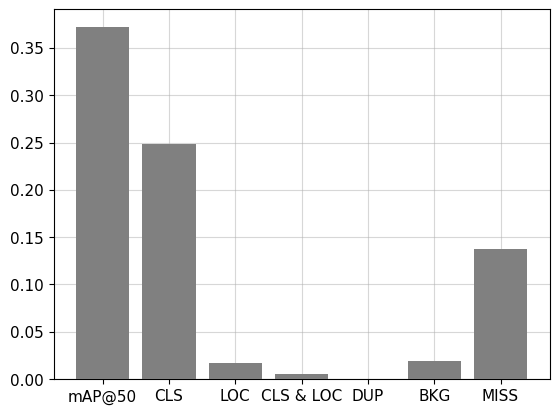

In [20]:
# Code not present in the article but used behind the scenes to generate the plot
order = ["mAP@50", "classification", "localization", "cls & loc", "duplicate", "background", "missed"]
labels = ["mAP@50", "CLS", "LOC", "CLS & LOC", "DUP", "BKG", "MISS"]
x = range(len(impact))
y = [impact[o] for o in order]
plt.bar(x, y, color="gray", tick_label=labels, zorder=10)
plt.grid(alpha=0.5, zorder=1)
plt.show()

In [64]:
#@title for evauluation
from pathlib import Path

import pandas as pd
from PIL import Image
import torch
import torchvision


def get_predictions(
    images_path: Path, images_df: pd.DataFrame, targets_df: pd.DataFrame
):
    """Get predictions and losses of `model` for all images in `images_df`
    :param model: Faster-RCNN PyTorch model.
    :param images_df: DataFrame with images.
    :param targets_df: DataFrame with ground truth target for images.
    :return preds_df: DataFrame with columns
        [
            "pred_id", "image_id", "image_loss", "label_id", "score",
            "xmin", "ymin", "xmax", "ymax"
        ]
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True
    )

    device = (
        torch.device("cuda:0")
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
    model = model.to(device)

    preds_dfs = []
    for sample in images_df.itertuples():
        # We iterate over single samples (batch size of 1) because we need one
        # loss per image and PyTorch Faster-RCNN outputs losses per batch,
        # not sample.
        t_df = targets_df.query("image_id == @sample.image_id")

        image = Image.open(images_path / sample.file_name).convert("RGB")
        image_tensor = torchvision.transforms.ToTensor()(image).to(device)

        bboxes = t_df[["xmin", "ymin", "xmax", "ymax"]].values
        labels = t_df["label_id"].values
        if bboxes.size == 0:
            # PyTorch Faster-RCNN expects targets to be tensors that fulfill
            # len(boxes.shape) == 2 & boxes.shape[-1] == 4
            bboxes = torch.empty(0, 4)

        targets = {
            "boxes": torch.as_tensor(bboxes, dtype=torch.float32).to(device),
            "labels": torch.as_tensor(labels, dtype=torch.int64).to(device),
        }
        with torch.no_grad():
            # Faster-RCNN outputs losses only when train mode
            model.train()
            losses = model([image_tensor], [targets])
            # Faster-RCNN outputs predictions only when eval mode
            model.eval()
            preds = model([image_tensor])
        # Unify all sublosses into one (this is just one way of doing it)
        loss = sum(losses.values()).item()

        preds_dfs.append(
            pd.DataFrame(
                {
                    "image_id": sample.image_id,
                    "image_loss": loss,
                    "label_id": preds[0]["labels"].to("cpu"),
                    "score": preds[0]["scores"].to("cpu"),
                    "xmin": preds[0]["boxes"][:, 0].to("cpu"),
                    "ymin": preds[0]["boxes"][:, 1].to("cpu"),
                    "xmax": preds[0]["boxes"][:, 2].to("cpu"),
                    "ymax": preds[0]["boxes"][:, 3].to("cpu"),
                }
            )
        )

    preds_df = pd.concat(preds_dfs, ignore_index=True)
    preds_df = preds_df.reset_index().rename(columns={"index": "pred_id"})
    return preds_df[
        [
            "pred_id",
            "image_id",
            "label_id",
            "xmin",
            "ymin",
            "xmax",
            "ymax",
            "score",
            "image_loss",
        ]
    ]

In [ ]:
preds_df = get_predictions(images_path, images_df, targets_df)